In [1]:
import xarray as xr
import pandas as pd
import pyproj

# 1. SETUP: Define your file and your points
filename = "ITS_LIVE_velocity_120m_RGI14A_2022_v02.nc"

# Replace this with: df = pd.read_csv("your_7000_glaciers.csv")
data = {
    'Name': ['Baltoro', 'Siachen', 'Biafo'],
    'Lat': [35.75, 35.50, 36.00], 
    'Lon': [76.50, 77.00, 75.90]
}
df = pd.DataFrame(data)

print(f"Loading local map: {filename} ...")

# 2. OPEN DATASET (Engine 'h5netcdf' is fast for local files)
ds = xr.open_dataset(filename, engine='h5netcdf')

# 3. COORDINATE TRANSFORMATION (Crucial Step)
# The map uses UTM (Meters). We must convert your Lat/Lon to matching Meters.

# Auto-detect the map's projection
try:
    # Most ITS_LIVE files store projection in 'mapping' variable
    crs_wkt = ds.mapping.attrs.get('crs_wkt', ds.mapping.attrs.get('spatial_ref'))
    proj_crs = pyproj.CRS.from_wkt(crs_wkt)
except:
    # Fallback for Pakistan if auto-detect fails
    print("Warning: Auto-detect failed. Forcing EPSG:32643 (Pakistan Zone 43N)")
    proj_crs = pyproj.CRS.from_epsg(32643)

# Create the translator: Lat/Lon -> Map Meters
transformer = pyproj.Transformer.from_crs("EPSG:4326", proj_crs, always_xy=True)

# Convert all 7,000 points instantly
xx, yy = transformer.transform(df['Lon'].values, df['Lat'].values)

# 4. EXTRACT VELOCITY
# .sel(method='nearest') finds the pixel the glacier sits on
print("Extracting velocities...")
velocities = ds.v.sel(x=xr.DataArray(xx, dims="points"), 
                      y=xr.DataArray(yy, dims="points"), 
                      method='nearest')

# 5. SAVE RESULTS
df['velocity_2022'] = velocities.values

print("\n--- RESULTS (Meters/Year) ---")
print(df)

# Optional: Save to new CSV
# df.to_csv("pakistan_glaciers_2022_velocity.csv", index=False)

Loading local map: ITS_LIVE_velocity_120m_RGI14A_2022_v02.nc ...
Extracting velocities...

--- RESULTS (Meters/Year) ---
      Name    Lat   Lon  velocity_2022
0  Baltoro  35.75  76.5     146.804123
1  Siachen  35.50  77.0     168.220474
2    Biafo  36.00  75.9      51.431080


In [2]:
# import xarray as xr
# import pandas as pd
# import pyproj

# # 1. LOAD DATA
# # Replace with: df = pd.read_csv("your_7000_glaciers.csv")
# # Creating dummy data for demonstration
# data = {
#     'Name': ['Glacier A', 'Glacier B', 'Glacier C', 'Glacier D', 'Glacier E'],
#     'Lat': [35.75, 35.50, 36.00, 34.20, 36.10], 
#     'Lon': [76.50, 77.00, 75.90, 73.50, 74.90]
# }
# df = pd.DataFrame(data)

# filename = "ITS_LIVE_velocity_120m_RGI14A_2022_v02.nc"
# ds = xr.open_dataset(filename, engine='h5netcdf')

# # 2. CONVERT COORDINATES (Lat/Lon -> Meters)
# # Auto-detect projection or force Pakistan zone
# try:
#     crs_wkt = ds.mapping.attrs.get('crs_wkt', ds.mapping.attrs.get('spatial_ref'))
#     proj_crs = pyproj.CRS.from_wkt(crs_wkt)
# except:
#     proj_crs = pyproj.CRS.from_epsg(32643)

# transformer = pyproj.Transformer.from_crs("EPSG:4326", proj_crs, always_xy=True)
# xx, yy = transformer.transform(df['Lon'].values, df['Lat'].values)

# # 3. EXTRACT VELOCITY
# velocities = ds.v.sel(x=xr.DataArray(xx, dims="points"), 
#                       y=xr.DataArray(yy, dims="points"), 
#                       method='nearest')

# df['speed_2022'] = velocities.values

# # 4. FILTER: FIND THE INTERESTING ONES
# # We remove any NaN (rock) values and sort by speed
# valid_glaciers = df.dropna(subset=['speed_2022'])
# top_candidates = valid_glaciers.sort_values(by='speed_2022', ascending=False).head(5)

# print("--- TOP 5 INTERESTING GLACIERS (Fastest) ---")
# print(top_candidates[['Name', 'Lat', 'Lon', 'speed_2022']])

d:\LUMS\SPROJ\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fetching data...


d:\LUMS\SPROJ\.venv\Lib\site-packages\itslive\velocity_cubes\_cubes.py:224: FutureWarning: In a future version, xarray will not decode the variable 'date_dt' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  xr_da = xr.open_dataset(


Success! Plotting 8536 points.


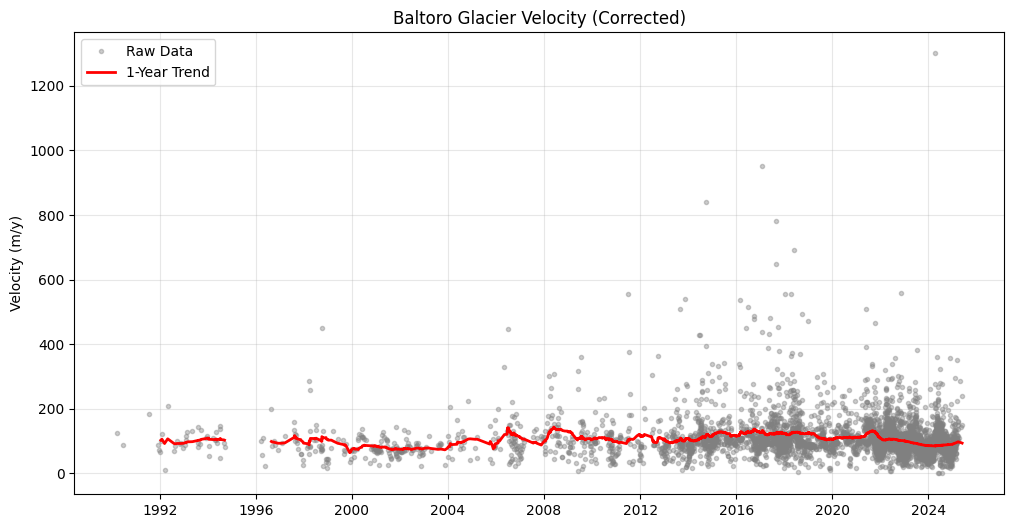

In [3]:
from itslive import velocity_cubes
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define Coordinates (Baltoro Glacier)
coords = [(76.42, 35.74)] 

print("Fetching data...")

try:
    # 2. Get Data
    raw_response = velocity_cubes.get_time_series(points=coords, variables=["v", "mid_date"])[0]
    
    # Drill down into the dataset
    data = raw_response['time_series']
    
    # 3. Extract Correct Columns
    # We use 'mid_date' (The Date) instead of 'date_dt' (The Duration)
    clean_data = {
        'Velocity': data['v'].values,       # .values ensures we get a simple array
        'Date': data['mid_date'].values     # .values ensures we get a simple array
    }
    
    # 4. Create DataFrame
    df = pd.DataFrame(clean_data)
    
    # 5. Clean & Plot
    # mid_date is already a datetime object, so we don't need pd.to_datetime()
    df = df.dropna()
    
    print(f"Success! Plotting {len(df)} points.")
    
    plt.figure(figsize=(12, 6))
    
    # Plot Raw Data (Gray dots)
    plt.plot(df['Date'], df['Velocity'], '.', color='gray', alpha=0.4, label='Raw Data')
    
    # Plot Trend (Red Line) - 1 Year Moving Average
    # '365D' handles irregular gaps in data better than simple numbers
    df = df.sort_values('Date').set_index('Date')
    trend = df['Velocity'].rolling('365D', min_periods=5).mean()
    
    plt.plot(trend.index, trend, color='red', linewidth=2, label='1-Year Trend')
    
    plt.title("Baltoro Glacier Velocity (Corrected)")
    plt.ylabel("Velocity (m/y)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

except Exception as e:
    print("Error:", e)

In [4]:
# pip install seaborn

1. Fetching Data...
{'requested_point_geographic_coordinates': (76.42, 35.74), 'returned_point_geographic_coordinates': (76.41964091008688, 35.73952370120308), 'returned_point_projected_coordinates': {'epsg': 32643, 'coords': (array(628372.5), array(3955987.5))}, 'returned_point_offset_from_requested_in_projection_meters': np.float64(62.01988504704663), 'time_series': <xarray.Dataset> Size: 6MB
Dimensions:         (mid_date: 124329)
Coordinates:
  * mid_date        (mid_date) datetime64[ns] 995kB 2022-05-27T05:37:39.22022...
    x               float64 8B 6.284e+05
    y               float64 8B 3.956e+06
Data variables:
    vx              (mid_date) float32 497kB ...
    vy_error        (mid_date) float32 497kB ...
    vy              (mid_date) float32 497kB ...
    satellite_img1  (mid_date) <U2 995kB ...
    v               (mid_date) float32 497kB ...
    v_error         (mid_date) float32 497kB ...
    vx_error        (mid_date) float32 497kB ...
    date_dt         (mid_date) t

C:\Users\alian\AppData\Local\Temp\ipykernel_66088\644519070.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Month', y='Velocity', data=df, palette="coolwarm")


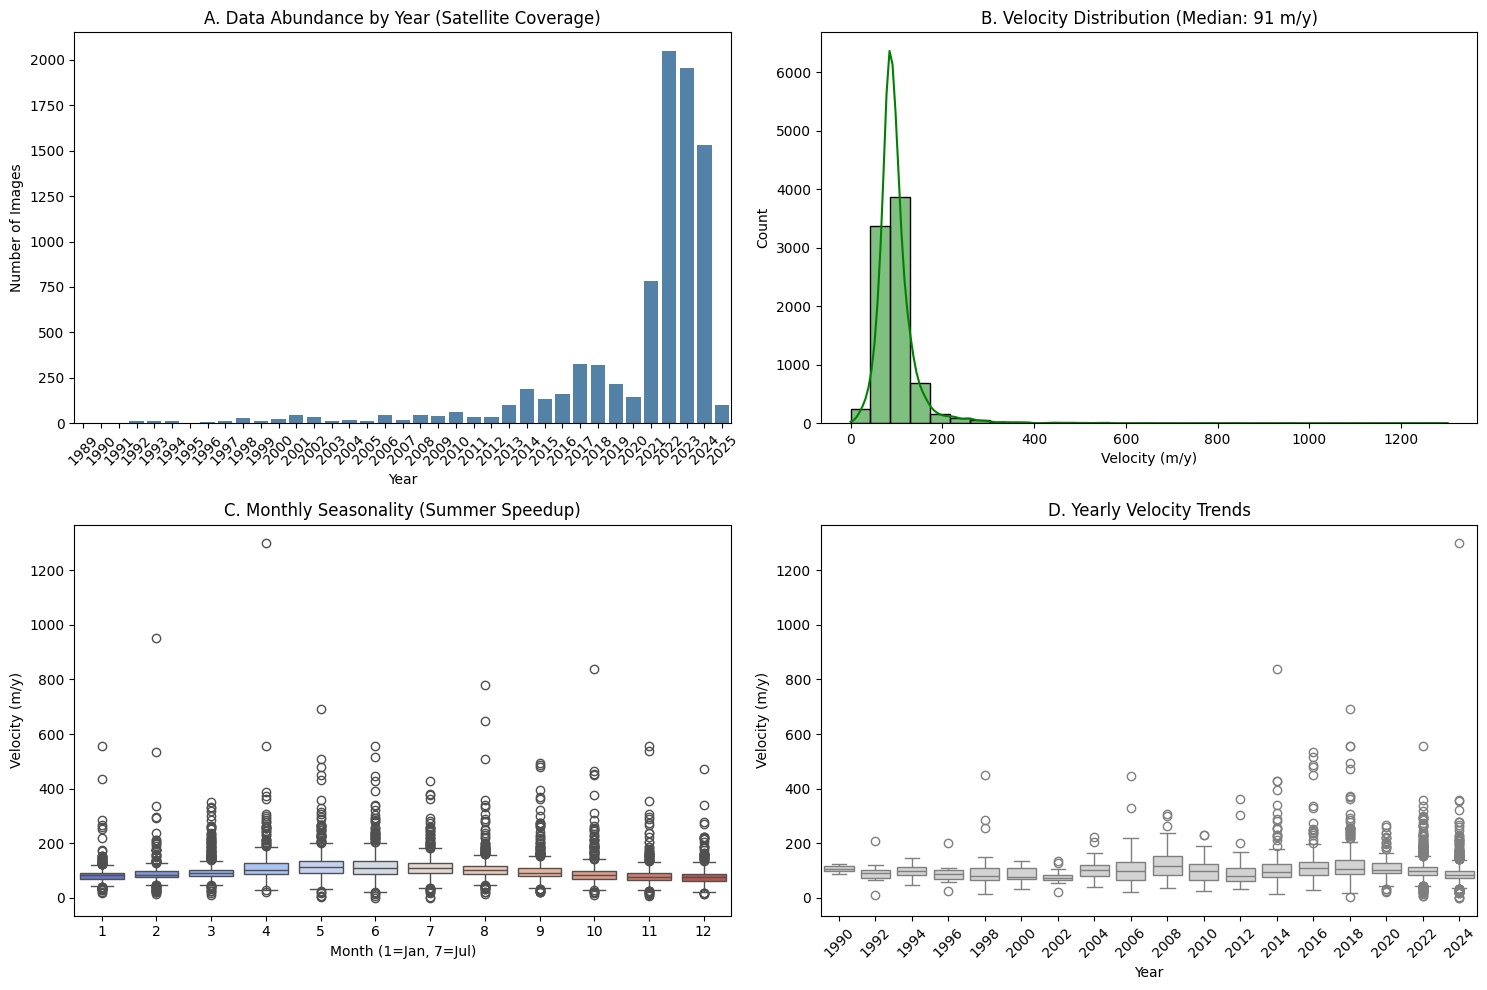

In [8]:
from itslive import velocity_cubes
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. DATA EXTRACTION (Recap of what worked) ---
coords = [(76.42, 35.74)] # Baltoro Central Flow
print("1. Fetching Data...")
raw_response = velocity_cubes.get_time_series(points=coords, variables=["v", "mid_date"])[0]
data = raw_response['time_series']

print(raw_response)


print("-----------------")

# Create DataFrame
df = pd.DataFrame({'Velocity': data['v'].values, 'Date': data['mid_date'].values})
df['Date'] = pd.to_datetime(df['Date'])
# df = df.dropna()

# Add helper columns for analysis
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

print(f"   -> Loaded {len(df)} data points from {df['Year'].min()} to {df['Year'].max()}.")

# --- 2. STATISTICAL SUMMARY ---
print("\n--- 2. Key Statistics ---")
print(df['Velocity'].describe().round(1))

# --- 3. VISUALIZATION ---
plt.figure(figsize=(15, 10))

# Plot A: Data Density (The "Satellite Revolution")
# Shows how many measurements we have per year.
plt.subplot(2, 2, 1)
counts = df.groupby('Year')['Velocity'].count()
sns.barplot(x=counts.index, y=counts.values, color='steelblue')
plt.title("A. Data Abundance by Year (Satellite Coverage)")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)

# Plot B: The Distribution (Histogram)
# Shows the most common speeds.
plt.subplot(2, 2, 2)
sns.histplot(df['Velocity'], bins=30, kde=True, color='green')
plt.title(f"B. Velocity Distribution (Median: {df['Velocity'].median():.0f} m/y)")
plt.xlabel("Velocity (m/y)")

# Plot C: Seasonality (The "Heartbeat")
# Do glaciers move faster in Summer?
plt.subplot(2, 2, 3)
sns.boxplot(x='Month', y='Velocity', data=df, palette="coolwarm")
plt.title("C. Monthly Seasonality (Summer Speedup)")
plt.xlabel("Month (1=Jan, 7=Jul)")
plt.ylabel("Velocity (m/y)")

# Plot D: Yearly Trend (Boxplots)
# Is the glacier speeding up or slowing down overall?
plt.subplot(2, 2, 4)
# We filter to show every 2nd year to keep the x-axis clean
sns.boxplot(x='Year', y='Velocity', data=df[df['Year'] % 2 == 0], color='lightgray')
plt.title("D. Yearly Velocity Trends")
plt.xticks(rotation=45)
plt.ylabel("Velocity (m/y)")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Assuming you already ran your code:
# raw_response = velocity_cubes.get_time_series(...)
# data = raw_response['time_series']

# Convert to a quick dataframe to analyze
df = pd.DataFrame({'Date': data['mid_date'], 'Velocity': data['v']})
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna/()

print("--- DATA AUDIT ---")
print(f"Total Measurements: {len(df):,}")
print(f"Start Date:         {df['Date'].min().date()}")
print(f"End Date:           {df['Date'].max().date()}")
print(f"Duration Covered:   {(df['Date'].max() - df['Date'].min()).days / 365.25:.1f} years")

TypeError: unsupported operand type(s) for /: 'method' and 'tuple'

Fetching data for Shisper Glacier...


d:\LUMS\SPROJ\.venv\Lib\site-packages\itslive\velocity_cubes\_cubes.py:224: FutureWarning: In a future version, xarray will not decode the variable 'date_dt' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  xr_da = xr.open_dataset(


Error: index values must be monotonic


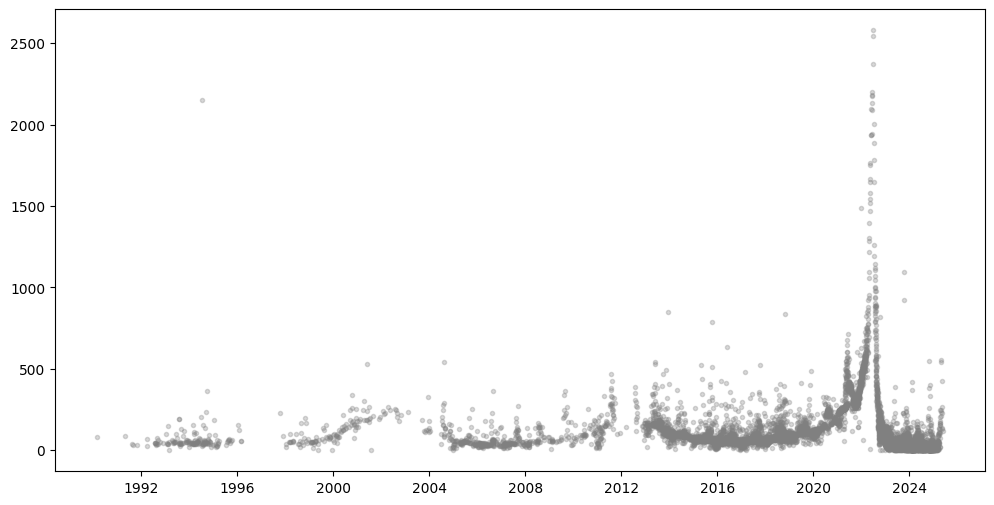

In [7]:
from itslive import velocity_cubes
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define Coordinates: Shisper Glacier (Hunza Valley)
coords = [(71.907, 38.837)] 

print("Fetching data for Shisper Glacier...")

try:
    # 2. Get Data
    raw_response = velocity_cubes.get_time_series(points=coords, variables=["v", "mid_date"])[0]
    data = raw_response['time_series']
    
    # 3. Extract & Clean
    df = pd.DataFrame({
        'Velocity': data['v'].values,
        'Date': pd.to_datetime(data['mid_date'].values)
    }).dropna()
    
    # Filter crazy outliers (clouds)
    df = df[df['Velocity'] < 5000]

    # 4. Plot
    plt.figure(figsize=(12, 6))
    
    # Raw dots
    plt.plot(df['Date'], df['Velocity'], '.', color='gray', alpha=0.3, label='Raw Data')
    
    # Trend Line (The Surge Signal)
    # Shisper surges are fast, so we use a shorter window (90 days) to catch the spike
    trend = df.set_index('Date')['Velocity'].rolling('90D', min_periods=3).mean()
    
    plt.plot(trend.index, trend, color='red', linewidth=2, label='Surge Trend')
    
    plt.title("Shisper Glacier: The 2018-2019 Surge Event")
    plt.ylabel("Velocity (m/y)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

except Exception as e:
    print("Error:", e)